# Circular orbit transfer problem

$$
\min_{\Delta v, \mathbf{x}(t)} \sum |\Delta v|^2
$$

subject to the dynamic constraints

$$
\begin{gather*}
\dot{r} = u \\
\dot{\theta} = v \\
\dot{u} = \frac{v^2}{r} - \frac{\mu}{r^2} \\
\dot{v} = -\frac{uv}{r}
\end{gather*}
$$

and boundary conditions

$$
\begin{gather*}
r(0) = r_0 \\
\theta(0) = 0 \\
u(0) = 0 \\
v(0) = \sqrt{\frac{\mu}{r_0}} \\
r(t_f) = r_f \\
\theta(t_f) = 0 \\
u(t_f) = 0 \\
v(t_f) = \sqrt{\frac{\mu}{r_f}}.
\end{gather*}
$$

There are three stages (although the OCP does not need to be constructed this way): an initial circular orbit, an elliptic orbit, and a final circular orbit.  Each pair of stages is joined by a $\Delta v$ maneuver, but the positions must be continuous.

In arbitrary units, $\mu = 1.0$, $r_0 = 1.0$, and $r_f = 1.5$.

(__TODO:__ Make this a real transfer from LEO to GEO)

In [1]:
import numpy as np

import archimedes as arc
from archimedes.experimental import coco as cc
import matplotlib.pyplot as plt

arc.theme.set_theme("dark")

%load_ext autoreload
%autoreload 2

# Single-stage problem

In [2]:
mu = 1.0
r0 = 1.0
rf = 1.5

nx, nu = 4, 0
t0 = 0.0


def j(t, x, phi, p):
    return 0.0


def f(t, x, phi, p):
    r, θ, u, v = x
    return np.array(
        [
            u,
            v / r,
            v**2 / r - mu / r**2,
            -u * v / r,
        ],
        like=x,
    )


def cost(x0, t0, xf, tf, q, p):
    return sum(p**2)  # Total delta-v expenditure


# Add impulsive (tangential) velocity at the beginning
def initial_constraint(boundary_data):
    dv1 = boundary_data.p[0]
    x0_transfer = np.array(
        [r0, 0.0, 0.0, np.sqrt(mu / r0) + dv1], like=boundary_data.x0
    )
    return x0_transfer - boundary_data.x0


# Final state of the transfer orbit should be the target orbit,
# less the impulsive (tangential) velocity change. The final anomaly
# is not constrained
def terminal_constraint(boundary_data):
    dv2 = boundary_data.p[1]
    xf = boundary_data.xf[[0, 2, 3]]
    xf_circular = np.array([rf, 0.0, np.sqrt(mu / rf) - dv2], like=boundary_data.xf)
    return xf_circular - xf


# Discretize the domain
N = [20]
knots = []
domain = cc.RadauFiniteElements(N=N, knots=knots)


# Boundary conditions
bcs = [
    cc.start_time(t0),
    cc.Constraint(initial_constraint, 4),
    cc.Constraint(terminal_constraint, 3),
]

# Define the problem in three stages
ocp = cc.OptimalControlProblem(
    nx=nx,
    nu=nu,
    np=2,
    ode=f,
    quad=j,
    cost=cost,
    boundary_constraints=bcs,
)

# Linearly interpolate initial guess
x0_guess = np.array([r0, 0.0, 0.0, np.sqrt(mu / r0)])
xf_guess = np.array([rf, np.pi, 0.0, np.sqrt(mu / rf)])
tf_guess = 4.5


def x_guess(t):
    return x0_guess + (t - t0) * (xf_guess - x0_guess) / (tf_guess - t0)


sol = ocp.solve(domain, t_guess=(t0, tf_guess), x_guess=x_guess)
sol.p


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1990
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:      222

Total number of variables............................:       88
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       88
Total number of inequality c

array([0.09544512, 0.08619984])

In [3]:
# Hohmann solution
dv1_ex = np.sqrt(mu / r0) * (np.sqrt(2 * rf / (r0 + rf)) - 1)
dv2_ex = np.sqrt(mu / rf) * (1 - np.sqrt(2 * r0 / (r0 + rf)))
dv1_ex, dv2_ex

(np.float64(0.09544511501033215), np.float64(0.08619983758750457))

Text(0.5, 0, '$t$')

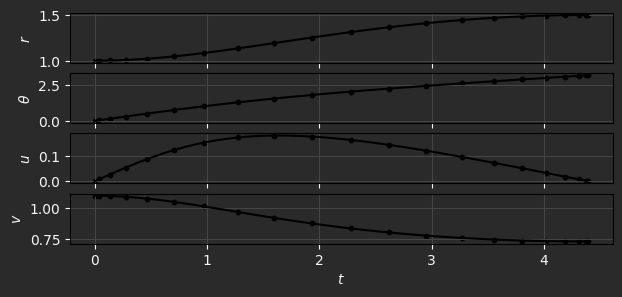

In [4]:
t_plt = np.linspace(t0, sol.tf, 100)
x_plt = sol.x(t_plt)

fig, ax = plt.subplots(4, 1, figsize=(7, 3), sharex=True)

ax[0].scatter(sol.tp, sol.xp[:, 0], s=10, c="k")
ax[0].plot(t_plt, x_plt[:, 0], "k")
ax[0].grid()
ax[0].set_ylabel("$r$")
ax[1].scatter(sol.tp, sol.xp[:, 1], s=10, c="k")
ax[1].plot(t_plt, x_plt[:, 1], "k")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].scatter(sol.tp, sol.xp[:, 2], s=10, c="k")
ax[2].plot(t_plt, x_plt[:, 2], "k")
ax[2].grid()
ax[2].set_ylabel("$u$")
ax[3].scatter(sol.tp, sol.xp[:, 3], s=10, c="k")
ax[3].plot(t_plt, x_plt[:, 3], "k")
ax[3].grid()
ax[3].set_ylabel("$v$")
ax[3].set_xlabel("$t$")

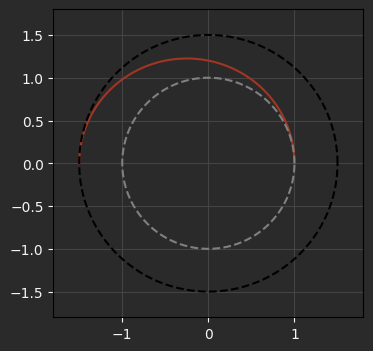

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

r, θ = x_plt[:, 0], x_plt[:, 1]
x, y = r * np.cos(θ), r * np.sin(θ)

rf = r[-1]
r0 = r[0]
rmax = max(r)

ax.plot(x, y, c="xkcd:brick")

θ = np.linspace(0, 2 * np.pi, 1000)
ax.plot(r0 * np.cos(θ), r0 * np.sin(θ), c="grey", ls="--")
ax.plot(rf * np.cos(θ), rf * np.sin(θ), c="k", ls="--")

ax.set_xlim([-1.2 * rmax, 1.2 * rmax])
ax.set_ylim([-1.2 * rmax, 1.2 * rmax])
ax.grid()
plt.show()

# Two-stage problem

Same basic problem, but add a constraint on the final anomaly so that the time of the transfer becomes part of the problem.  This simulates a rendezvous-type problem or falling into a specified GEO slot.

In [6]:
mu = 1.0
r0 = 1.0
rf = 1.5


nx, nu = 4, 0
x0 = np.array([r0, 0.0, 0.0, np.sqrt(mu / r0)])
xf = np.array([rf, 2 * np.pi, 0.0, np.sqrt(mu / rf)])
t0 = 0.0


def j(t, x, phi, p):
    return 0.0


def f(t, x, phi, p):
    r, θ, u, v = x
    return np.array(
        [
            u,
            v / r,
            v**2 / r - mu / r**2,
            -u * v / r,
        ],
        like=x,
    )


def cost_stage1(x0, t0, xf, tf, q, p):
    return sum(p**2)  # Total delta-v expenditure


def cost_stage2(x0, t0, xf, tf, q, p):
    return sum(p**2)  # Total delta-v expenditure


# State continuity between stages
def stage_constraint(boundary_data):
    bd1, bd2 = boundary_data
    bd2_x0 = bd1.xf
    bd2_x0[3] += bd1.p  # Add delta-v to tangential velocity
    return bd2_x0 - bd2.x0


def terminal_constraint(boundary_data):
    dv2 = boundary_data.p
    stage_xf = boundary_data.xf
    xf_circular = np.array([xf[0], xf[1], xf[2], xf[3] - dv2], like=stage_xf)
    return xf_circular - stage_xf


# Discretize the domain (same for all three stages)
N = [20]
knots = []
stage_domain = cc.RadauFiniteElements(N=N, knots=knots)


# Boundary conditions for each stage
bcs1 = [cc.start_time(t0), cc.initial_condition(x0)]
bcs2 = [cc.Constraint(terminal_constraint, 4)]

# Define the problem in three stages
stage1 = cc.OptimalControlProblem(
    nx=nx,
    nu=nu,
    np=1,
    ode=f,
    quad=j,
    cost=cost_stage1,
    boundary_constraints=bcs1,
)

stage2 = cc.OptimalControlProblem(
    nx=nx,
    nu=nu,
    np=1,
    ode=f,
    quad=j,
    cost=cost_stage2,
    boundary_constraints=bcs2,
)

# Define the full problem
ocp = cc.MultiStageOptimalControlProblem(
    stages=[stage1, stage2],
    stage_constraints=[
        cc.Constraint(stage_constraint, 4),
    ],
)


domain = [stage_domain, stage_domain]

# Linearly interpolate initial guess
tf_guess = 5.0


def x_guess(t):
    return x0 + (t - t0) * (xf_guess - x0) / (tf_guess - t0)


t_guess = np.linspace(t0, tf_guess, 3)
sol = ocp.solve(domain, x_guess=x_guess)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3981
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:      442

Total number of variables............................:      174
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      174
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.65e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [7]:
sol[0].p, sol[1].p  # Should match the single-stage values exactly

(array([0.09544512]), array([0.08619984]))

Text(0.5, 0, '$t$')

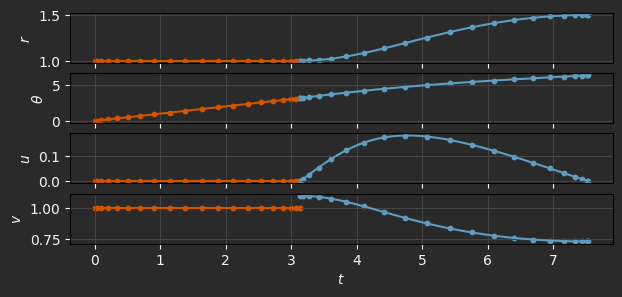

In [8]:
fig, ax = plt.subplots(4, 1, figsize=(7, 3), sharex=True)

for i in range(len(sol)):
    t_plt = np.linspace(sol[i].t0, sol[i].tf, 100)
    x_plt = sol[i].x(t_plt)

    (l,) = ax[0].plot(t_plt, x_plt[:, 0])
    ax[0].scatter(sol[i].tp, sol[i].xp[:, 0], s=10, c=l.get_color())

    ax[1].plot(t_plt, x_plt[:, 1], c=l.get_color())
    ax[1].scatter(sol[i].tp, sol[i].xp[:, 1], s=10, c=l.get_color())

    ax[2].plot(t_plt, x_plt[:, 2], c=l.get_color())
    ax[2].scatter(sol[i].tp, sol[i].xp[:, 2], s=10, c=l.get_color())

    ax[3].plot(t_plt, x_plt[:, 3], c=l.get_color())
    ax[3].scatter(sol[i].tp, sol[i].xp[:, 3], s=10, c=l.get_color())


ax[0].grid()
ax[0].set_ylabel("$r$")
ax[1].grid()
ax[1].set_ylabel(r"$\theta$")
ax[2].grid()
ax[2].set_ylabel("$u$")
ax[3].grid()
ax[3].set_ylabel("$v$")
ax[3].set_xlabel("$t$")

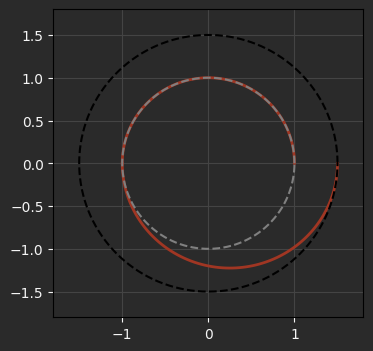

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

for i in range(len(sol)):
    t_plt = np.linspace(sol[i].t0, sol[i].tf, 100)
    x_plt = sol[i].x(t_plt)
    r, θ = x_plt[:, 0], x_plt[:, 1]
    x, y = r * np.cos(θ), r * np.sin(θ)

    ax.plot(x, y, lw=2, c="xkcd:brick")

θ = np.linspace(0, 2 * np.pi, 1000)
ax.plot(r0 * np.cos(θ), r0 * np.sin(θ), c="grey", ls="--")
ax.plot(rf * np.cos(θ), rf * np.sin(θ), c="k", ls="--")

ax.set_xlim([-1.2 * rf, 1.2 * rf])
ax.set_ylim([-1.2 * rf, 1.2 * rf])
ax.grid()
plt.show()